In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import treecorr
import healpy as hp
import os

from importlib import reload

import somoclu

import time

start_time = time.time()

import sys
sys.path.append('src')

In [2]:
GETBACK=sys.path

In [3]:
current_path = os.getcwd()  # Obtiene el directorio actual
parent_path = os.path.dirname(current_path)  # Sube un nivel
os.chdir(parent_path)  # Cambia al directorio padre
sys.path = os.getcwd()

In [4]:
GETBACK2=sys.path

In [5]:
catwo = pd.read_parquet("property_maps_desy3_small.parquet.gzip")
catwo = catwo.drop(['HPIX_4096','FOREGROUND_MASK','BADREGIONS_MASK','EBV_SFD98'], axis=1)
catwo = catwo.iloc[0:0]

In [6]:
sys.path=GETBACK2
os.chdir("Modulos")

In [7]:
MainArray = np.loadtxt("Main_Parmeters.txt")

In [8]:
som_dim = int(MainArray[0])
JoyDiv=int(MainArray[1])
dif=int(MainArray[2])
JD=int(MainArray[3])
SJ=int(MainArray[4])
Bin=0

del MainArray

In [9]:
cat = pd.read_parquet("property_maps_desy3Groups.parquet.gzip")

In [10]:
num_subsets=100
subset_size=len(cat['HPIX_4096'])

In [11]:
MagicianRed = pd.read_parquet("MagicianRedFULL.parquet.gzip")

In [12]:
import numpy as np
import pandas as pd

BOOTS = pd.DataFrame()

# Preprocesar agrupaciones por HPIX_4096 y grupos
MagicianRed_grouped = MagicianRed.groupby('HPIX_4096')['NewWeights'].sum()
MagicianRed_counts = MagicianRed['HPIX_4096'].value_counts()
cat_grouped = cat.set_index('HPIX_4096')

for MAP in catwo.columns:
    print(MAP)
    
    Delta_WWF = np.zeros((num_subsets, JD))  # Matriz preasignada
    Delta_NWF = np.zeros((num_subsets, JD))  # Matriz preasignada
    
    for i in range(num_subsets):        
        subset = np.random.choice(cat['HPIX_4096'].values, size=subset_size, replace=True)
        
        Sub_densities_WW = MagicianRed_grouped.reindex(subset, fill_value=0).values
        Sub_densities_NW = MagicianRed_counts.reindex(subset, fill_value=0).values
        
        Clusteringo = cat_grouped.loc[subset, 'Group_' + MAP].fillna(-1).astype(int).values
        
        unique_clusters, cluster_counts = np.unique(Clusteringo, return_counts=True)
        
        Sub_Areas = np.zeros(JD, dtype=int)
        Sub_Areas[unique_clusters] = cluster_counts
        Sub_AreaT = Sub_Areas.sum()
        
        SUB_DensityT_WW = Sub_densities_WW.sum() / Sub_AreaT
        SUB_DensityT_NW = Sub_densities_NW.sum() / Sub_AreaT
        
        norm_densities_WW = np.zeros(JD, dtype=float)
        norm_densities_NW = np.zeros(JD, dtype=float)

        mask = Clusteringo[:, None] == unique_clusters  # Matriz booleana para selección rápida
        norm_densities_WW[unique_clusters] = np.where(
            Sub_Areas[unique_clusters] > 0,
            np.sum(Sub_densities_WW[:, None] * mask, axis=0) / Sub_Areas[unique_clusters],
            0
        )
        norm_densities_NW[unique_clusters] = np.where(
            Sub_Areas[unique_clusters] > 0,
            np.sum(Sub_densities_NW[:, None] * mask, axis=0) / Sub_Areas[unique_clusters],
            0
        )

        Delta_WWF[i] = norm_densities_WW / SUB_DensityT_WW - 1
        Delta_NWF[i] = norm_densities_NW / SUB_DensityT_NW - 1
    
    # Asignar resultados finales al DataFrame
    BOOTS[MAP + '_WW'] = list(Delta_WWF)
    BOOTS[MAP + '_NW'] = list(Delta_NWF)

DEPTH_MOF_G
DEPTH_MOF_I
DEPTH_MOF_R
DEPTH_MOF_Z
EBV_PLANCK13
FWHM_WMEAN_G
SKYVAR_UNCERTAINTY_G
EXPTIME_SUM_G
AIRMASS_WMEAN_G
FWHM_WMEAN_I
SKYVAR_UNCERTAINTY_I
EXPTIME_SUM_I
AIRMASS_WMEAN_I
FWHM_WMEAN_R
SKYVAR_UNCERTAINTY_R
EXPTIME_SUM_R
AIRMASS_WMEAN_R
FWHM_WMEAN_Z
SKYVAR_UNCERTAINTY_Z
EXPTIME_SUM_Z
AIRMASS_WMEAN_Z
NSTAR_GAIA_DR3
FRACDET


In [13]:
mean_WW=[[np.mean(np.array([(BOOTS[elem+'_WW'][i][j]) for i in range(num_subsets)])) for j in range(JD)] for elem in (catwo.columns)]
mean_NW=[[np.mean(np.array([(BOOTS[elem+'_NW'][i][j]) for i in range(num_subsets)])) for j in range(JD)] for elem in (catwo.columns)]

In [14]:
Bootstrap_Err_WW=[[np.sqrt((np.sum([((BOOTS[catwo.columns[elem]+'_WW'][i][j])-mean_WW[elem][j])**2 for i in range(num_subsets)]))/(num_subsets-1)) for j in range(JD)] for elem in range(len(catwo.columns))]
Bootstrap_Err_NW=[[np.sqrt((np.sum([((BOOTS[catwo.columns[elem]+'_NW'][i][j])-mean_NW[elem][j])**2 for i in range(num_subsets)]))/(num_subsets-1)) for j in range(JD)] for elem in range(len(catwo.columns))]

In [15]:
Position_in_plot = [np.loadtxt("Modulo_PosicionesFINAL.txt")[i * JD: (i + 1) * JD] for i in range(len(catwo.columns))]
ClstDEN_Original = [np.loadtxt("ClstDEN_Original.txt")[i * JD: (i + 1) * JD] for i in range(len(catwo.columns))]
ClstDEN_Corrected = [np.loadtxt("ClstDEN_Corrected.txt")[i * JD: (i + 1) * JD] for i in range(len(catwo.columns))]

In [16]:
sys.path=GETBACK

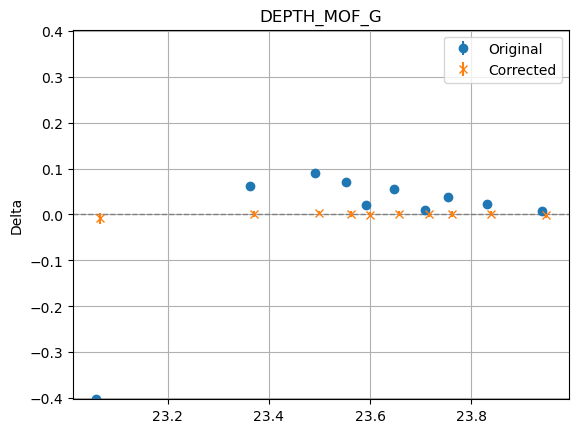

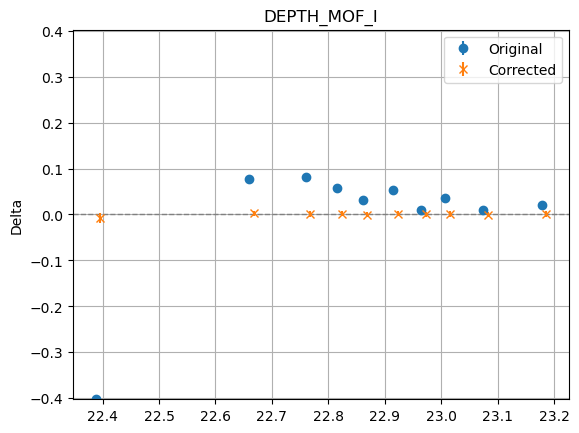

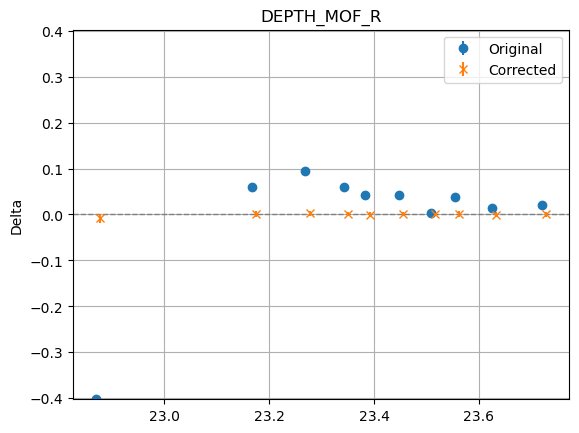

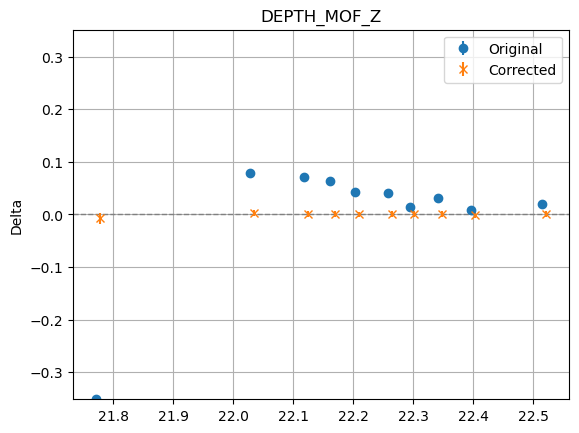

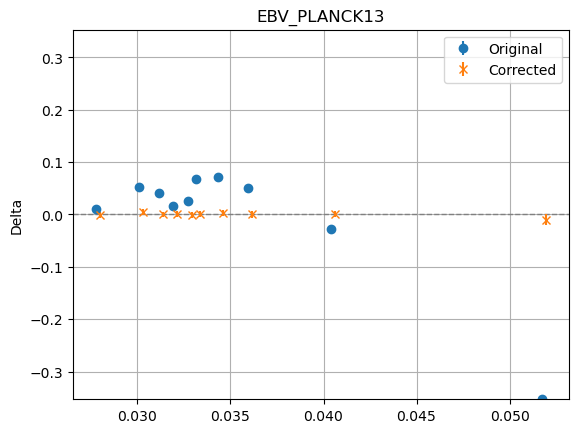

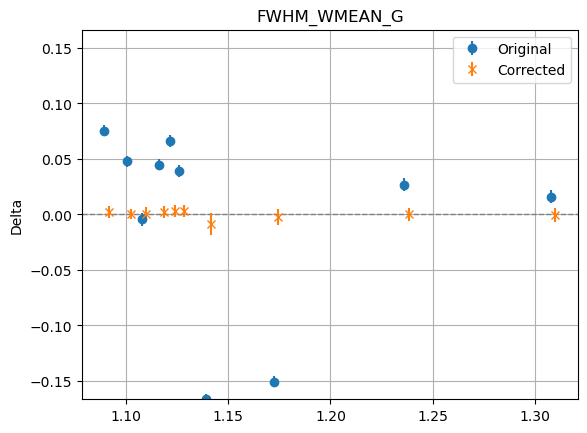

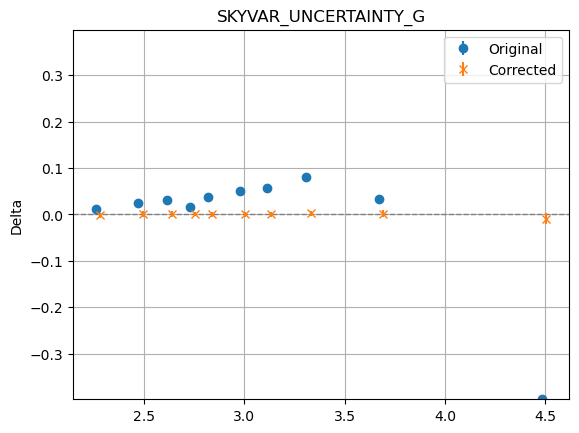

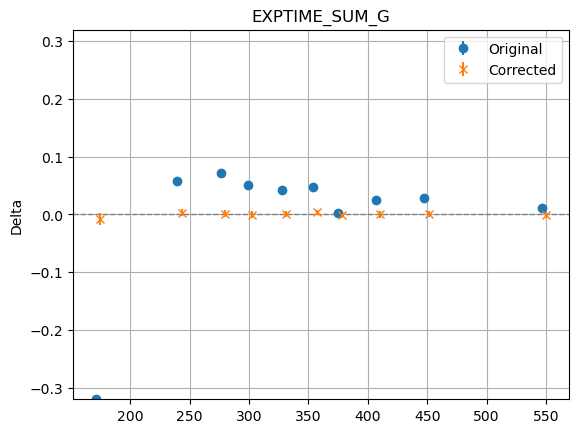

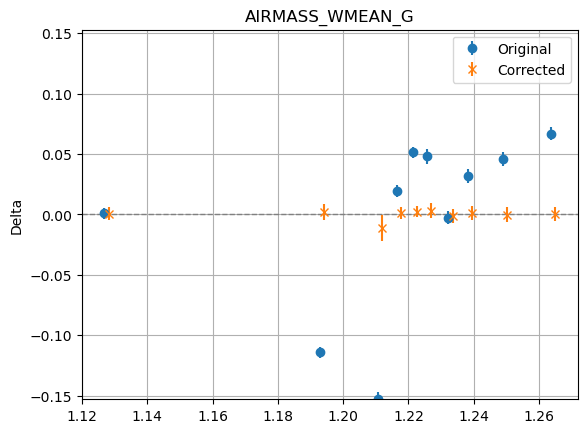

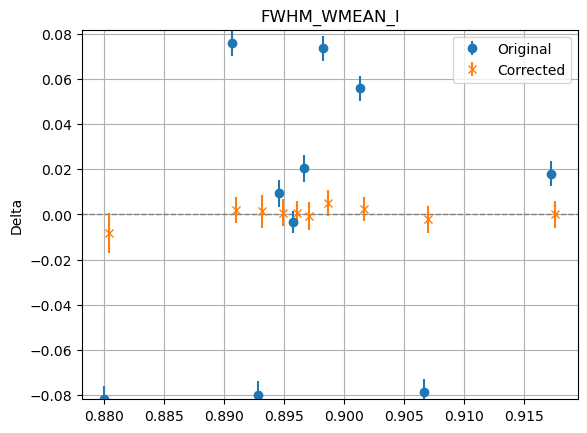

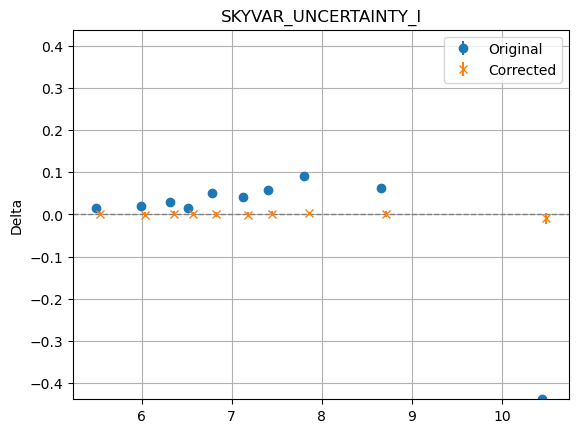

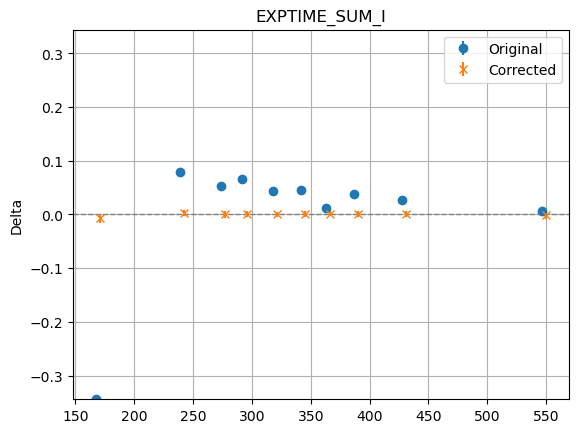

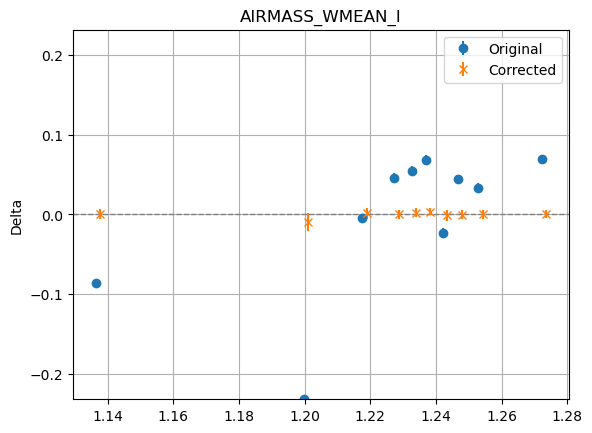

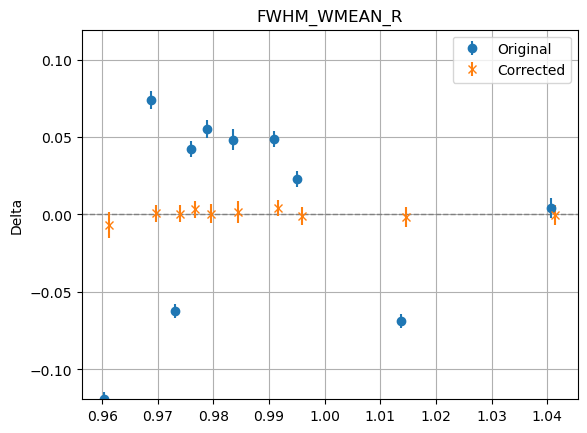

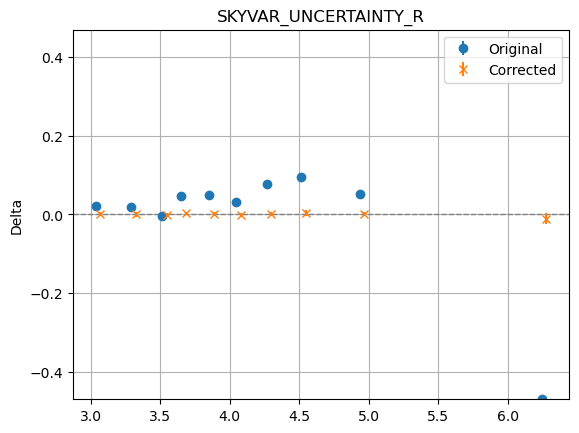

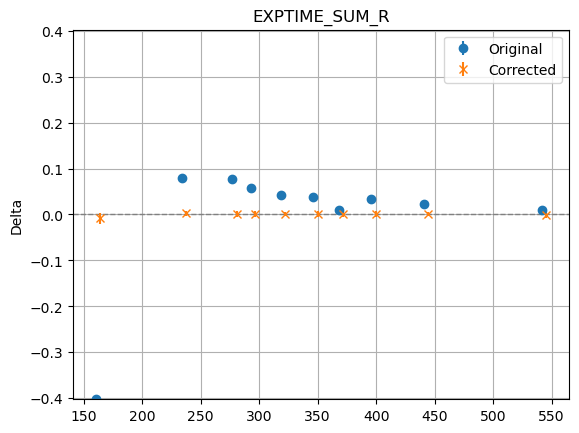

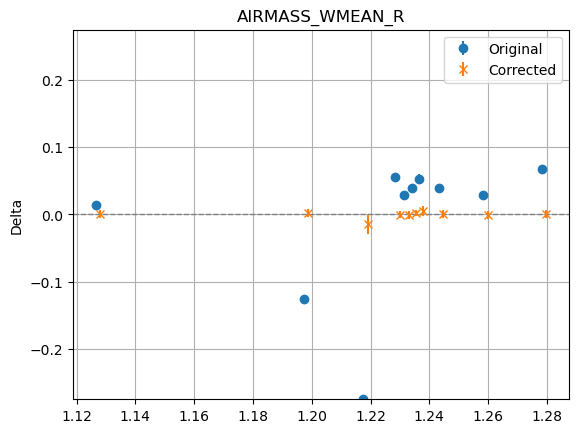

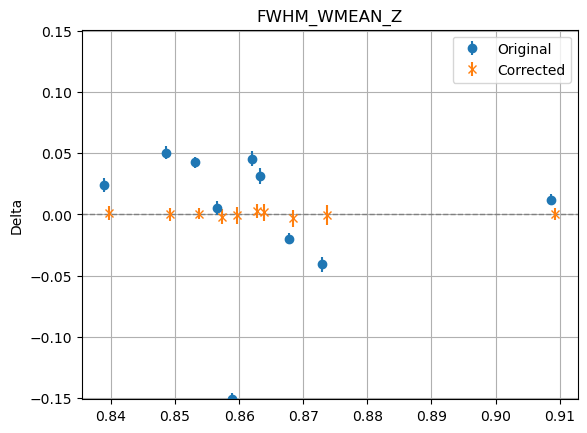

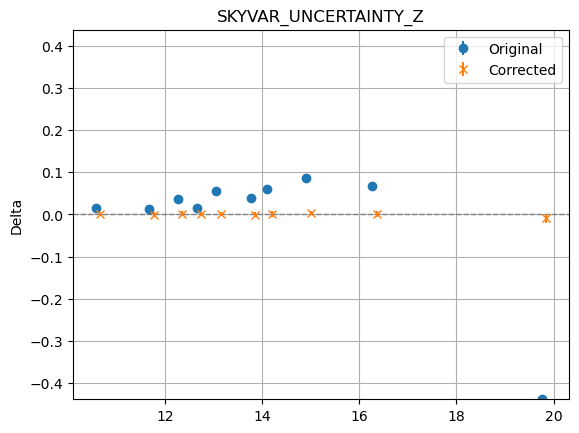

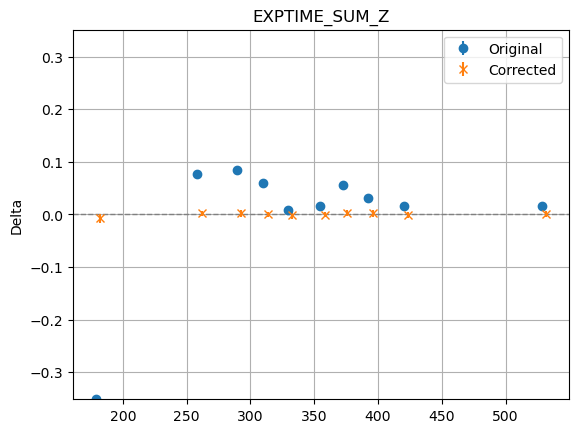

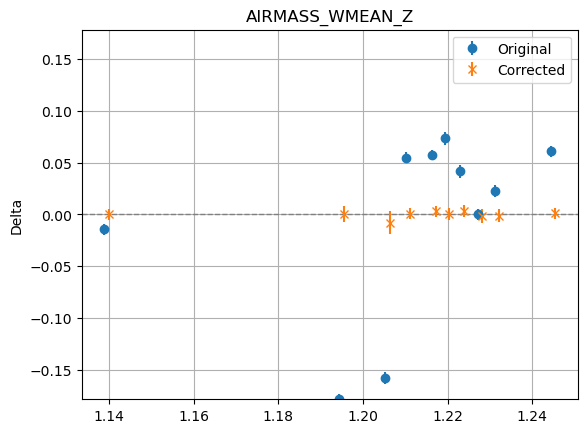

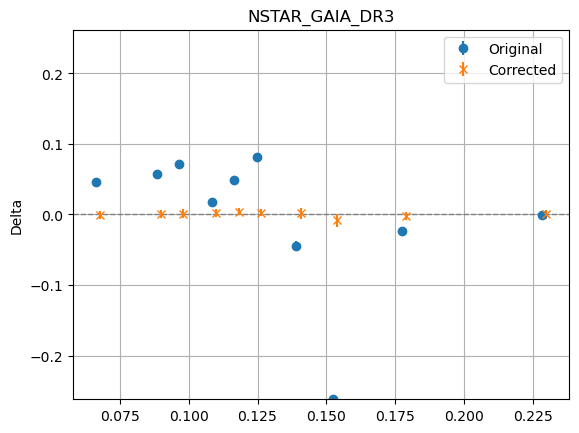

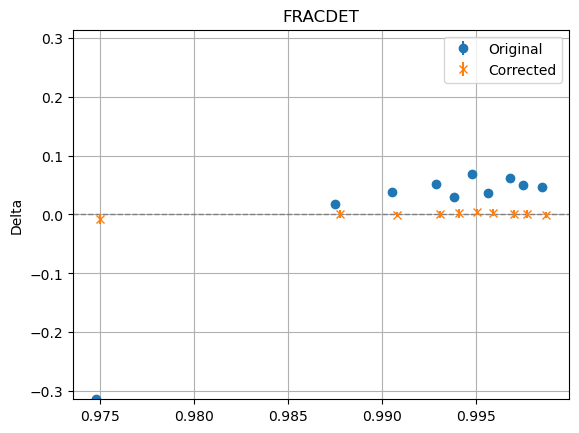

In [17]:
#output_folder = "Fits"

for i in range(len(catwo.columns)):
    Limits = max([max(abs(ClstDEN_Original[i])), max(abs(ClstDEN_Corrected[i]))])
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.errorbar(
        (Position_in_plot[i]-(np.max(Position_in_plot[i])-np.min(Position_in_plot[i]))/(20*JD)), ClstDEN_Original[i],
        yerr=Bootstrap_Err_NW[i], fmt='o', label='Original'
    )
    plt.errorbar(
        (Position_in_plot[i]+(np.max(Position_in_plot[i])-np.min(Position_in_plot[i]))/(20*JD)), ClstDEN_Corrected[i],
        yerr=Bootstrap_Err_WW[i], fmt='x', label='Corrected'
    )
    plt.ylim(-Limits, Limits)
    plt.ylabel('Delta')
    plt.title(catwo.columns[i])
    plt.legend()
    plt.grid()
    #filename = os.path.join(output_folder, f"plot_{catwo.columns[i]}_WE.png")
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [18]:
# Preprocesar agrupaciones por HPIX_4096 y grupos
MagicianRed_grouped = MagicianRed.groupby('HPIX_4096')['NewWeights'].sum()
MagicianRed_counts = MagicianRed['HPIX_4096'].value_counts()
cat_grouped = cat.set_index('HPIX_4096')
Delta_WWF=[]
Delta_NWF=[]

for i in range(num_subsets):        
    #subset = subsets[i]
    subset = np.random.choice(np.array(cat['HPIX_4096']), size=subset_size, replace=True)
        
    Sub_densities_WW = MagicianRed_grouped.reindex(subset, fill_value=0).values
    Sub_densities_NW = MagicianRed_counts.reindex(subset, fill_value=0).values
        
    Clusteringo = cat_grouped.loc[subset, 'Group'].fillna(-1).astype(int).values
        
    unique_clusters, cluster_counts = np.unique(Clusteringo, return_counts=True)
    Sub_Areas = np.zeros(JoyDiv, dtype=int)
    Sub_Areas[unique_clusters] = cluster_counts
    Sub_AreaT = Sub_Areas.sum()
        
    SUB_DensityT_WW = Sub_densities_WW.sum() / Sub_AreaT
    SUB_DensityT_NW = Sub_densities_NW.sum() / Sub_AreaT
        
    norm_densities_WW = np.zeros_like(Sub_Areas, dtype=float)
    norm_densities_NW = np.zeros_like(Sub_Areas, dtype=float)
        
        
    for clust in unique_clusters:
        mask = Clusteringo == clust
        norm_densities_WW[clust] = float(Sub_densities_WW[mask].sum() / (Sub_Areas[clust]))
        norm_densities_NW[clust] = float(Sub_densities_NW[mask].sum() / (Sub_Areas[clust]))
        
    Delta_WW = norm_densities_WW / SUB_DensityT_WW - 1
    Delta_NW = norm_densities_NW / SUB_DensityT_NW - 1
        
    # Acumular resultados
    Delta_WWF.extend([Delta_WW])
    Delta_NWF.extend([Delta_NW])
    
# Asignar resultados finales al DataFrame
BOOTS['Group_WW'] = Delta_WWF
BOOTS['Group_NW'] = Delta_NWF

In [19]:
del Delta_WWF
del Delta_NWF

In [20]:
mean_WW=[np.mean(np.array([(BOOTS['Group_WW'][i][j]) for i in range(num_subsets)])) for j in range(JoyDiv)]
mean_NW=[np.mean(np.array([(BOOTS['Group_NW'][i][j]) for i in range(num_subsets)])) for j in range(JoyDiv)]

In [21]:
Bootstrap_Err_WW=[np.sqrt((np.sum([((BOOTS['Group_WW'][i][j])-mean_WW[j])**2 for i in range(num_subsets)]))/(num_subsets-1)) for j in range(JoyDiv)]
Bootstrap_Err_NW=[np.sqrt((np.sum([((BOOTS['Group_NW'][i][j])-mean_NW[j])**2 for i in range(num_subsets)]))/(num_subsets-1)) for j in range(JoyDiv)]

In [22]:
clustering = np.loadtxt("Modulo_ClusteringBMUS.txt")

In [23]:
clustering

array([89., 26., 52., ..., 23., 23., 44.], shape=(10000,))

In [24]:
BErr_WW=[Bootstrap_Err_WW[int(i)] for i in (clustering)]
BErr_NW=[Bootstrap_Err_NW[int(i)] for i in (clustering)]

In [33]:
np.savetxt("NW_Error.txt", Bootstrap_Err_NW, fmt="%.15f")
np.savetxt("WW_Error.txt", Bootstrap_Err_WW, fmt="%.15f")

NameError: name 'Bootstrap_Err_NW' is not defined

In [25]:
del mean_WW
del mean_NW
del Bootstrap_Err_WW
del Bootstrap_Err_NW

(array([3.621e+03, 2.240e+03, 1.831e+03, 7.930e+02, 5.770e+02, 1.910e+02,
        3.670e+02, 1.900e+01, 4.500e+01, 5.700e+01, 0.000e+00, 7.200e+01,
        2.900e+01, 6.100e+01, 0.000e+00, 9.000e+00, 1.500e+01, 0.000e+00,
        2.000e+01, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 7.000e+00,
        0.000e+00, 0.000e+00, 1.100e+01, 0.000e+00, 0.000e+00, 4.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 6.000e+00, 6.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

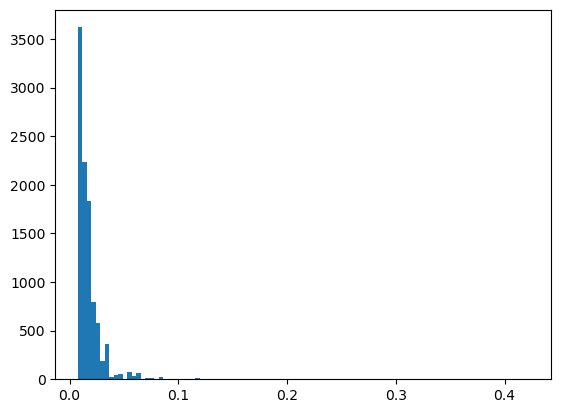

In [26]:
plt.hist(BErr_WW,100)

(array([5.190e+02, 5.003e+03, 1.943e+03, 1.259e+03, 4.610e+02, 4.130e+02,
        1.540e+02, 4.200e+01, 4.100e+01, 1.500e+01, 2.500e+01, 1.900e+01,
        1.800e+01, 3.500e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 1.400e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

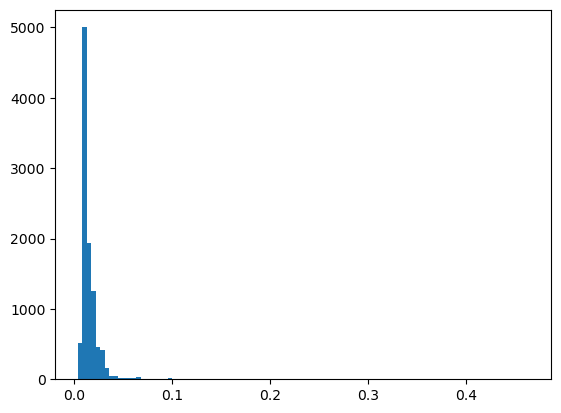

In [27]:
plt.hist(BErr_NW,100)

In [28]:
delta=np.loadtxt("delta.txt")
delta2=np.loadtxt("delta2.txt").reshape(((som_dim+dif), som_dim))

In [29]:
SOM = np.loadtxt("Modulo_SOM_RESULTS.txt").reshape((som_dim+dif),som_dim,len(catwo.columns))

In [30]:
from matplotlib import cm
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

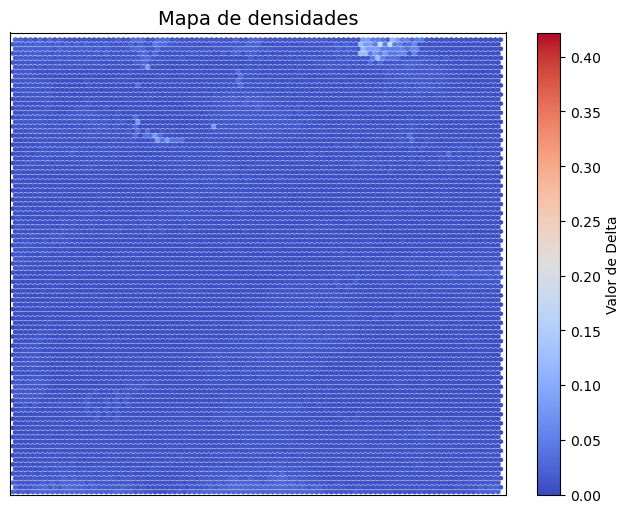

In [31]:
p_low, p_high = np.nanpercentile(delta, [5, 95])#-->La información es mas visualmente entendible

BErr_WW=np.array(BErr_WW)
BErr_NW=np.array(BErr_NW)

BErr_WW[BErr_WW == 0] = np.nan
BErr_NW[BErr_NW == 0] = np.nan

if abs(np.nanmax(BErr_WW))>abs(np.nanmin(BErr_NW)):
    lim3=abs(np.nanmax(BErr_WW))
else:
    lim3=abs(np.nanmax(BErr_NW))

BErr_WW = BErr_WW.reshape(SOM.shape[1], SOM.shape[0])
BErr_NW = BErr_NW.reshape(SOM.shape[1], SOM.shape[0])

#delta3=np.clip(delta,p_low,p_high)
#delta3 = (delta3 - min(delta3)) / (max(delta3) - min(delta3)) 

#BErr_WW=BErr_WW.T
#BErr_NW=BErr_NW.T

#delta3=delta*(lim2/lim)+1-(lim2/lim)

fig, ax = plt.subplots(figsize=(8, 6))
hex_size = 1

cmap = plt.cm.coolwarm

for i in range(delta2.shape[0]):
    for j in range(delta2.shape[1]):
        y = i * hex_size * np.sqrt(3) 
        x = j * hex_size * 3/2 + (i%2) * hex_size *  3/4 

        hexagon = RegularPolygon((x, y), numVertices=6, radius=hex_size, 
                                 orientation=np.radians(0), 
                                 facecolor=cmap(BErr_WW[i, j]))
        ax.add_patch(hexagon)
        #ax.text(x, y, f'{delta2[i, j]*(np.max(delta) - np.min(delta))+np.min(delta):.3f}', ha='center', va='center', color='black', fontsize=8)

ax.set_xlim(-hex_size, (delta2.shape[1]) * hex_size * 3/2+1)
ax.set_ylim(-hex_size, (delta2.shape[0]) * hex_size * np.sqrt(3)+1)

ax.set_title('Mapa de densidades', fontsize=14)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=lim3))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Valor de Delta')

plt.xticks([])
plt.yticks([])

#filename = os.path.join("plots",f"Mapa_Densidades_ConPesos_ErrCOMP.png") 
#plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()


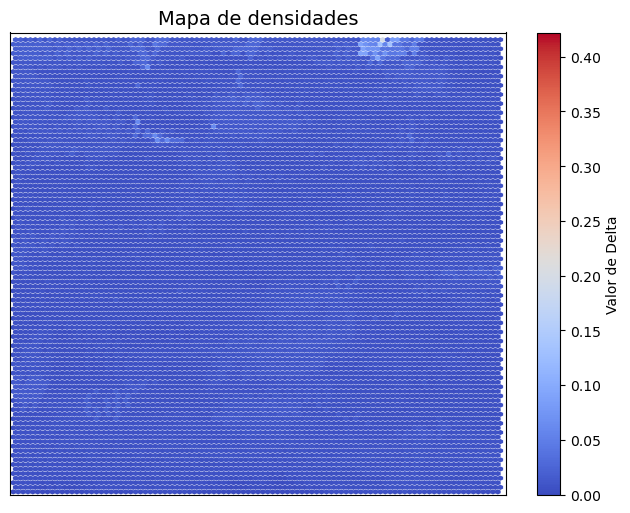

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
hex_size = 1

cmap = plt.cm.coolwarm

for i in range(delta2.shape[0]):
    for j in range(delta2.shape[1]):
        y = i * hex_size * np.sqrt(3) 
        x = j * hex_size * 3/2 + (i%2) * hex_size *  3/4 

        hexagon = RegularPolygon((x, y), numVertices=6, radius=hex_size, 
                                 orientation=np.radians(0), 
                                 facecolor=cmap(BErr_NW[i, j]))
        ax.add_patch(hexagon)
        #ax.text(x, y, f'{delta2[i, j]*(np.max(delta) - np.min(delta))+np.min(delta):.3f}', ha='center', va='center', color='black', fontsize=8)

ax.set_xlim(-hex_size, (delta2.shape[1]) * hex_size * 3/2+1)
ax.set_ylim(-hex_size, (delta2.shape[0]) * hex_size * np.sqrt(3)+1)

ax.set_title('Mapa de densidades', fontsize=14)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=lim3))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Valor de Delta')

plt.xticks([])
plt.yticks([])

#filename = os.path.join("plots",f"Mapa_Densidades_SinPesos_ErrCOMP.png") 
#plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()